In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make gif

In [2]:
# import imageio
# gif_path = './logs/gifs/'
# filenames = [gif_path + file for file in os.listdir(gif_path)]
# epoch = [int(file.rstrip('.png').split('_')[-1]) for file in filenames]
# sorted_filenames = [x for _, x in sorted(zip(epoch, filenames), key=lambda pair: pair[0])]
# images = []
# for filename in sorted_filenames:
#     images.append(imageio.imread(filename))
# imageio.mimsave('./logs/heatmap_anim.gif', images)

# Post-processing

### Get predictions

In [3]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'brown', 'pink', 'purple', 'k', 'gray', 'olive']

In [4]:
predictions = np.load('./outputs/predictions.npz')
ids, coords, dists, labels = predictions.values()

ids.shape, coords.shape, dists.shape, labels.shape

((46,), (46, 13), (46, 13, 512, 1), (46, 13))

In [21]:
list(ids).index('fr_552_TS_Sag')


20

### Get ground-truth data

In [5]:
def get_gt(id_):
    path = f'./data/testing/targets/'
    # Coordinates
    coord_path = path + f'coordinates/{id_}.csv'
    coords = pd.read_csv(coord_path)
    # Heatmaps
    dist_path = path + f'heatmaps/{id_}.npy'
    dists = np.load(dist_path)
    display(coords)
    return coords, dists

In [49]:
def plot_dist(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.axhline(0, ls='--', c='k')
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            tgt = gt_targets[:, 0, channel]
            data = dist[channel]
            ax.plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
            ax.plot(x, data, ls='--', label=vert, lw=3, color=colors[channel])
    ax.legend()

fr_552_TS_Sag


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


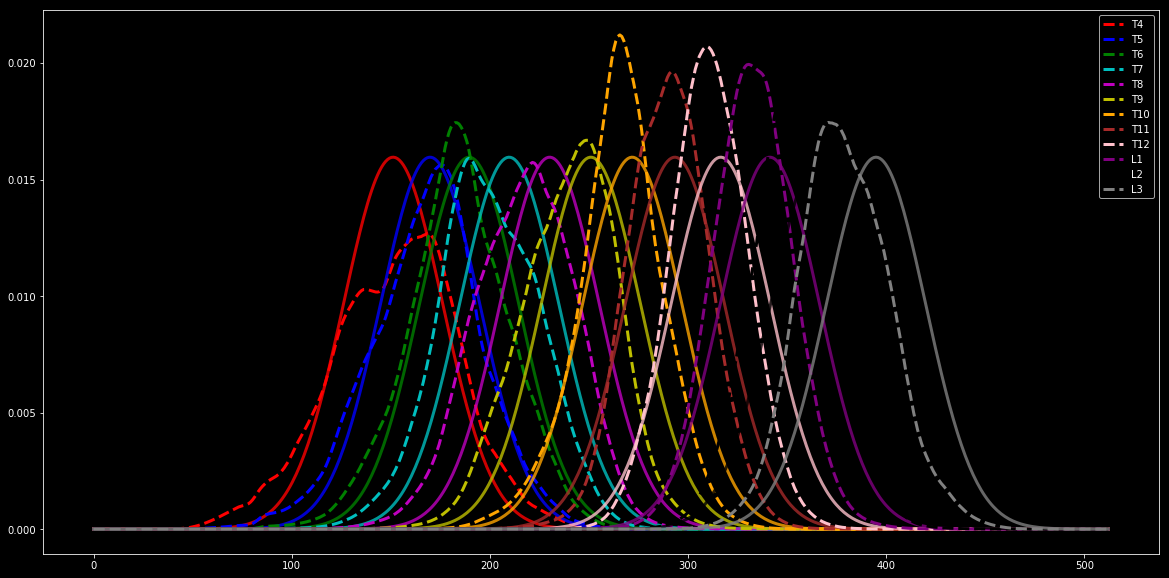

In [50]:
plot_dist(20)

In [8]:
def post(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    new_dist = np.zeros_like(dist)
    print(new_dist.shape)
    for pix in range(dist.shape[-1]):
        channel = np.argmax(dist[:, pix])
        new_dist[channel, pix] = np.max(dist[:, pix])
    
    print(new_dist.shape)
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.axhline(0, ls='--', c='k')
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            tgt = gt_targets[:, 0, channel]
            data = new_dist[channel]
            ax.plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
            ax.plot(x, data, ls='--', label=vert, lw=3, color=colors[channel])
    ax.legend()

fr_553_LS_Sag


,Level,Coordinate
0,L4,240.605529
1,T11,127.974665
2,L1,169.362515
3,L2,188.007883
4,L3,212.837283
5,T12,150.888818


(13, 512)
(13, 512)


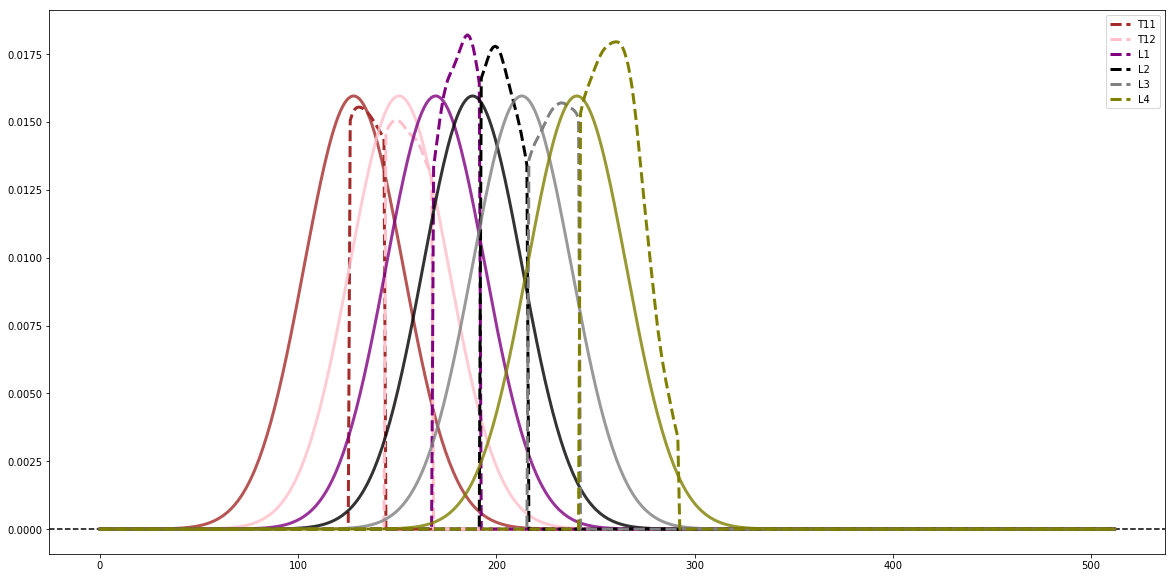

In [9]:
post(1)

In [10]:
from scipy.ndimage import zoom
import scipy.stats as ss

In [11]:
# ground-truth and prediction colormaps
g_cmap= sns.cubehelix_palette(start=0, rot=0, hue=1.5, gamma=1, as_cmap=True)
p_cmap = sns.cubehelix_palette(start=0.5, rot=-1., hue=1, gamma=1, as_cmap=True)

In [12]:
def plot_heatmap(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets = get_gt(id_)
    plt.style.use('dark_background')
    #P = ss.multivariate_normal.fit(dist)
    #print(P)
    dist = zoom(input=dist, zoom=(10, 1), order=1)
    rand = np.random.rand(512, 130)
    gt_targets = zoom(input=gt_targets[:, 0], zoom=(1, 10), order=1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    
    ax[0].imshow(dist.T, cmap=p_cmap)
    ax[1].imshow(gt_targets, cmap=p_cmap)
    return dist

fr_552_TS_Sag


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


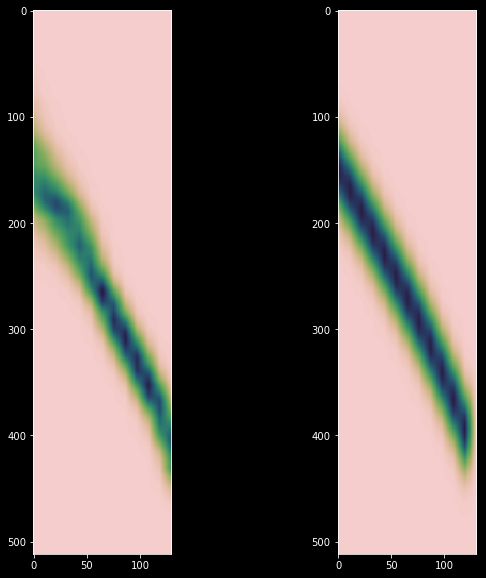

In [22]:
dist = plot_heatmap(20)

In [46]:
def js_reg(p, q):
    #~ Jensen-Shannon Divergence
    #@params:
    # *pred + target are 1D heatmaps
    assert p.shape == q.shape, 'Predicted heatmap not same shape as target'
    #* JS(P||Q) = 0.5*D(P||M) + 0.5*D(Q||M)
    #*M = 0.5*(P+Q)
    m = 0.5*(p + q)
    return 0.5*kl_reg(p, m) + 0.5*kl_reg(q, m)

def kl_reg(q, p):
    #~ Kullback-Leibler Divergence
    eps=1e-24
    #* D(P||Q) = P log P/Q 
    #* Add small constant to keep log finite
    unsummed_kl = p *(np.log((p+eps))- np.log((q+eps)))
    return unsummed_kl

In [51]:
def js_div(n):
    eps = 3e-28
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.axhline(0, ls='--', c='k')
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            tgt = gt_targets[:, 0, channel]
            data = dist[channel]
            js_div = kl_reg(tgt, data)
            
            ax.plot(x, js_div, lw=3, color=colors[channel], label=vert)
#             ax.plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
#             ax.plot(x, data, ls='--', label=vert, lw=3, color=colors[channel])
    ax.legend()

fr_552_TS_Sag


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


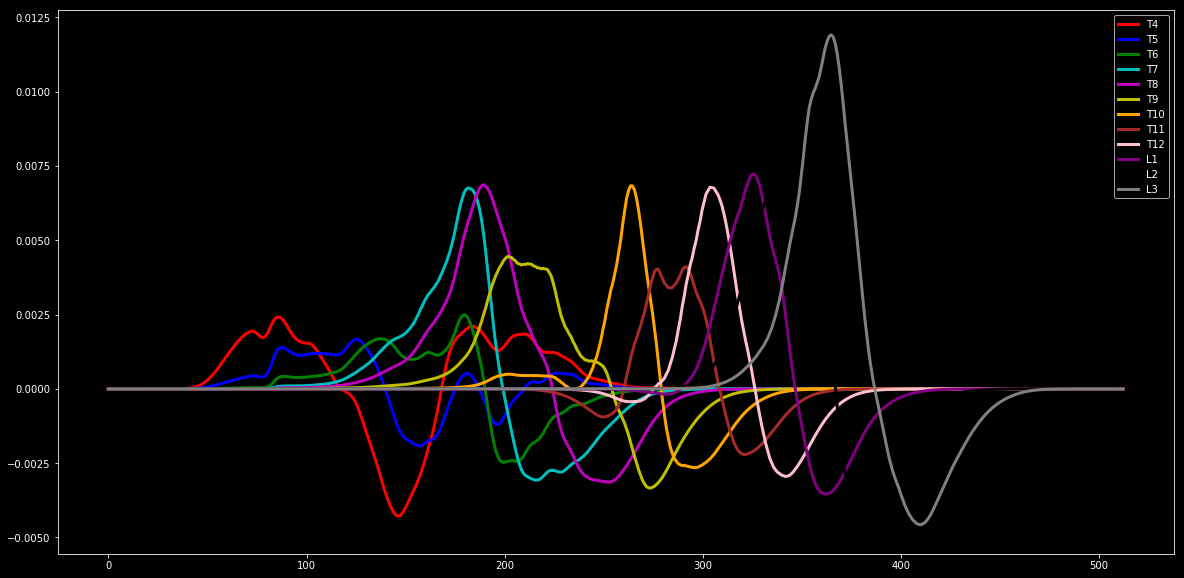

In [52]:
js_div(20)